# MAKEMORE
generates more things like these from file (char level generative model)

In [94]:
words = open("names.txt", 'r').read().splitlines()


In [95]:
words[:10], len(words), min(len(w) for w in words), max(len(w) for w in words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033,
 2,
 15)

## Bigrams

### on dictionary

In [96]:
b = {}

for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # add special chars for start and end
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1 # increment count

sorted(b.items(), key=lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

### On tensor

In [97]:
import torch

# mappings chars to indexes
chars = sorted(list(set(''.join(words)))) 
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0   # '<S>' and <E> can be one char because <S> is never in the end and <E> is never in the beginning, so it would generate row and col full of zeros
 
itos = {i: s for s, i in stoi.items()}

In [98]:
# count bigrams
N = torch.zeros((27, 27), dtype = torch.int32) # alphabet + start + end

for w in words:
    chs = ['.'] + list(w) + ['.'] # add special chars for start and end
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

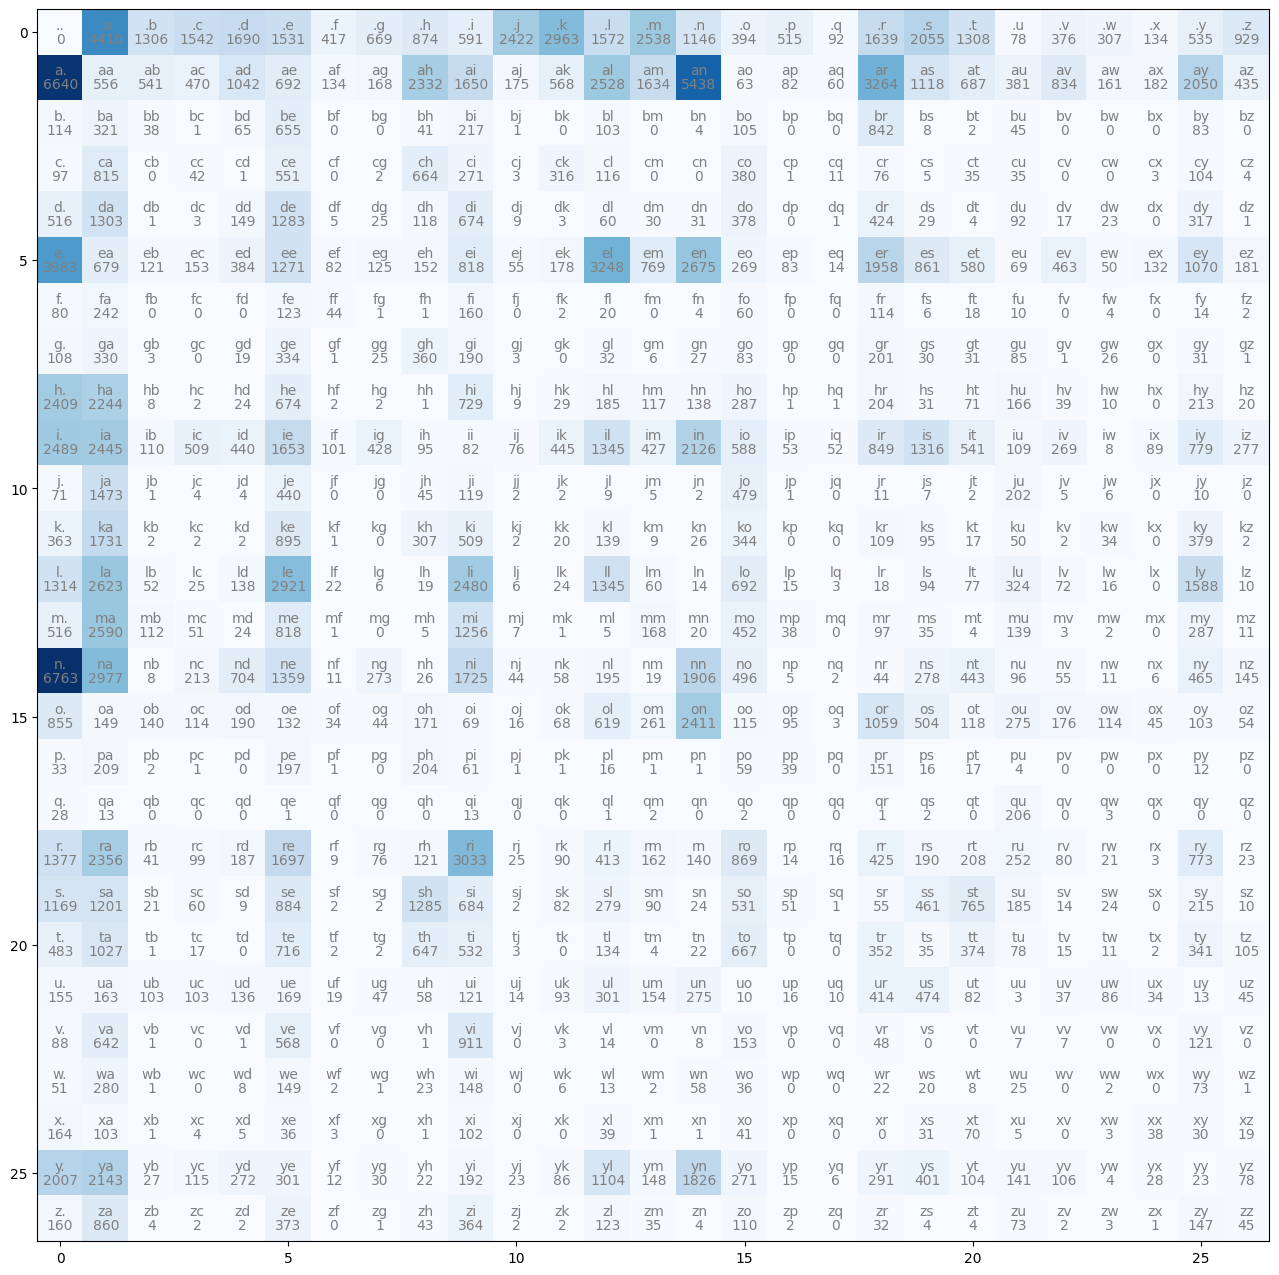

In [99]:
# visualise counts

import matplotlib.pyplot as plt
%matplotlib inline

def show_bigram_mtx(mtx):
    plt.figure(figsize=(16, 16))
    plt.imshow(mtx, cmap="Blues")
    for i in range(mtx.shape[0]):
        for j in range(mtx.shape[1]):
            chstr = itos[i] + itos[j] # bigram
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, round(mtx[i, j].item(), 2), ha="center", va="top", color="gray")

show_bigram_mtx(N)

In [100]:
# normalise by row

P = (N + 1).float() # add smoothing
P /= P.sum(dim=1, keepdim=True) 
####
# (27, 27), (27, 1)
# for broadcasting (can we combine the matrices in binary operation) we go from the trailing dimention (right to left) and
# the dimentions must be equal, one of them is 1 or one of them does not exis
# in our case it's true. for 27 and 1 1 == 1, and then 27 == 27
# it copies the column vector 27 times and then divides elementwise
##
# if we didn't do keepdim it would be (27, 27) and (27). It would treat it as (27, 27) and ( ,27) = (1, 27). It works, but
# these would create a row vector, dividing each column by the sum of rows, creating total garbage
####
P[0].sum() # it's 1 → ok

tensor(1.)

In [101]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # sample according to probabilities
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

junide.
janasah.
p.
cony.
a.


### Evaluate

Likelihood = probablity of an entire dataset given by our model (should be v. high).

Wiarygodność to, w uproszczeniu, prawdopodobieństwo parametru w konkretnym kontekście ustalonych obserwacji i modelu. Ma podobną postać do prawdopodobieństwa danych dla parametru (czyli funkcji gęstości lub masy), ale przyjmuje odwrotnie to, który czynnik jest losowy, a który stały.

We calculate it as a product of the probabilities of each bigram in the dataset.
However it'd be a very tiny number, so we take the log of it – log likelihood. 

![logarithm.png](logarithm.png)

log(a\*b\*c) = log(a) + log(b) + log(c)

We can see that the higher the better here. And for a loss we need to minimize it (lower the better), so we have to inverse it.
The lowest is now 0.

We can take the average, so it won't depend on the length of the dataset.

Now we can change the parameters (here the array) to maximize the likelihood of the dataset, by minimizing the average negative log likelihood loss.

For unknown words the model would say the probability of 0, so the nll of infinity. We can use smoothing, adding a small value to each count. This is called Laplace smoothing.


In [102]:
# count bigrams
log_likelihood = 0.0
n = 0

for w in words:
# for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.'] # add special chars for start and end
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        # the probabilities for the training set examples should be higher than 1/27 = 0.037. 
        # For a good model close to 1 (we're correctly predicting the future)
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}") 
print(f"{nll/n=}") # it should be close to 0

# after smoothing jq is very unlikely but it's still possible


log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
nll/n=tensor(2.4544)


## On neural network

### Deriving it

#### Create the training set

In [114]:
xs, ys = [], []

for w in words[:1]:    
    chs = ['.'] + list(w) + ['.'] # add special chars for start and end
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
# torch.tensor infers the dtype from the input and torch.Tensor takes float32. So it's better to use torch.tensor

In [115]:
# one-hot encoding
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() # we can feed NN only with floats

(torch.float32, torch.Size([5, 27]))

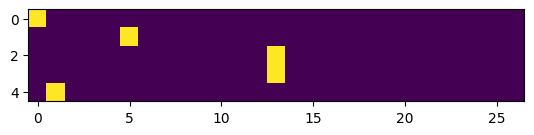

In [116]:
plt.imshow(xenc)
xenc.dtype, xenc.shape

#### Network

Only one layer of 27 neurons (one for each letter)

In [117]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g) # random from normal. 27 inputs, 27 neurons for each input. In columns are next neurons

In [118]:
logits = (xenc @ W) # log-counts
# softmax – normalize to sum to one and be all positive
counts = logits.exp() # equivalent N (counts)
probs = counts/ counts.sum(1, keepdims=True)
probs[0].sum()

tensor(1.0000)

In [119]:
xenc @ W    # (n, ~27~) @ (~27~, 27) = (n, 27)
(xenc @ W) [3, 13] # 13th neuron for 3rd input

tensor(0.0379)

In [120]:
# track ".emma." example
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    print("--------------------")
    print(f"bigram example {i}: {itos[x]}{itos[y]} ({x}, {y})")
    p = probs[i, y]
    print("probability assigned by net to the correct char", p.item())
    logp = torch.log(p)
    print("log likelihood", logp.item())
    nll = -logp
    print("negative log likelihood", nll.item())
    nlls[i] = nll

print("============")
print("average nll, i.e. loss", nlls.mean().item())

--------------------
bigram example 0: .e (0, 5)
probability assigned by net to the correct char 0.01228625513613224
log likelihood -4.399273872375488
negative log likelihood 4.399273872375488
--------------------
bigram example 1: em (5, 13)
probability assigned by net to the correct char 0.018050700426101685
log likelihood -4.014570713043213
negative log likelihood 4.014570713043213
--------------------
bigram example 2: mm (13, 13)
probability assigned by net to the correct char 0.026691533625125885
log likelihood -3.623408794403076
negative log likelihood 3.623408794403076
--------------------
bigram example 3: ma (13, 1)
probability assigned by net to the correct char 0.07367686182260513
log likelihood -2.6080665588378906
negative log likelihood 2.6080665588378906
--------------------
bigram example 4: a. (1, 0)
probability assigned by net to the correct char 0.014977526850998402
log likelihood -4.201204299926758
negative log likelihood 4.201204299926758
average nll, i.e. loss 3.7

### Learning nn

In [121]:
xs, ys = [], []

for w in words:    
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples", num)

xenc = F.one_hot(xs, num_classes=27).float()

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # random from normal. 27 inputs, 27 neurons for each input. In columns are next neurons
# the closer all W are to 0, the closer the output is to uniform distribution, similarily to smoothing in the counting model

number of examples 228146


In [124]:
# gradient descent
for k in range(10):
    # forward pass
    logits = xenc @ W # getting one-hot encoded x and multiplying it by W gets X[idx(x)]
    counts = logits.exp()
    probs = counts/ counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()  # probs[0,5], probs[1,13], probs[2,13], ...
    loss += 0.001*(W**2).mean() # regularisation component – tries to keep W close to 0
    print(loss.item())

    # backward pass
    W.grad = None # it's more efficient than assigning zeros
    loss.backward()

    # update
    W.data += -50 * W.grad

2.464237928390503
2.4641988277435303
2.464160442352295
2.4641220569610596
2.4640843868255615
2.4640469551086426
2.464010000228882
2.463973045349121
2.4639370441436768
2.4639008045196533


For the counting we achieved 2.47, we assume we can get the same for the neural network.

### Sample

In [112]:
g = torch.Generator().manual_seed(2147483647)

for i in range (5):
    out = []
    ix = 0
    while True:
        # counting approach
        # p = P[ix]

        # neural network approach
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts/ counts.sum(1, keepdims=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

juwjde.
janaqydjufhfbywe.
nn.
ksh.
ritoleras.


They give the same results, because they do roughly the same thing in other approaches.